<a href="https://colab.research.google.com/github/sweety-12/DeepFake-detection-project/blob/main/Deep_Fake_detection_using_Deep_Learning_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up Coding Environment**

In [1]:
#install necessary packages
!pip install -q torch torchvision torchaudio   #pytorch for buildidng and training models
!pip install -q matplotlib scikit-learn opencv-python   #for plotting and image handling
!pip install -q albumentations tqdm    #for data augmentation and progress bars



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00


**Import Libraries**

In [2]:
#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

#other libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

**Dataset Collection**

Get a dataset that contains both real and fake images for training your model

we will use the fake and reak faces dataset for easier and fater training at the start.

In [3]:
from google.colab import files
files.upload()  #upload the kaggle.json file here

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sweetykumari12082001","key":"0de9bae6201f343ff38dd6ef734be170"}'}

Authenticate and Download Dataset

In [4]:
#save the key and download the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Download the fake and real dataset(small and good for starters)
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip -q real-and-fake-face-detection.zip -d data

Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0


**Data Preprocessing and DataLoader Creation**

This step will prepare the image so your model can understand and learn from them

In [5]:
from PIL import Image
#These help standardize and augment the input data

from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  #Convert all images to RGB
    transforms.Resize((128, 128)),   #Resize all images to 128x128
    transforms.ToTensor(),            #Convert to PyTorch tensor(0-1 range)
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  #Normalize to [-1, 1]
])

**Load Dataset using ImageFolder**

Imagefolder automatically labels folders real - 0, fake - 1.

In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

#load dataset
dataset = ImageFolder("data/real_and_fake_face", transform=transform)

#split into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#create DataLoaders(batch size = 32)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

#check classes
print("Classes:", dataset.classes)  #['fake', 'real']

Classes: ['training_fake', 'training_real']


Visualize Sample Images

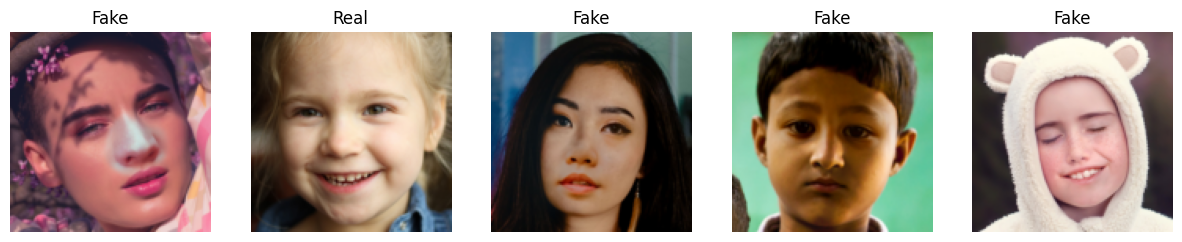

In [7]:
def show_batch(loader):
  images, labels = next(iter(loader))
  fig, ax = plt.subplots(1, 5, figsize=(15, 3))
  for i in range(5):
    img = images[i].permute(1,2, 0)* 0.5 + 0.5  #undo normalization
    label = "Real" if labels[i] == 1 else "Fake"
    ax[i].imshow(img)
    ax[i].set_title(label)
    ax[i].axis('off')


show_batch(train_loader)


# Build the Deep Fake Detection Model

Create a Convolutional Neural Network(CNN) that learns to classify images as real(1) or fake (0)

**Define a Simple CNN Architecture**

we'll keep it simple to start with and later i can experiment with advanced models and ResNet, Efficient, or Xception

In [13]:
class DeepFakeCNN(nn.Module):
  def __init__(self):
    super(DeepFakeCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size =3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(64 * 16 * 16, 128)
    self.fc2 = nn.Linear(128, 1)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 64 * 16 * 16)
    x = self.dropout(F.relu(self.fc1(x)))
    x = torch.sigmoid(self.fc2(x))
    return x

**Initialize Model, Loss and Optimizer**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeCNN().to(device)

#Binary classification = use BCE Loss
criterion = nn.BCELoss()

#Adam optimizer(you can experiment later)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Training Function**

Here we'll loop over epochs, update weights and print training loss.

In [15]:
def train(model, loader, optimizer, criterion):
  model.train()
  running_loss = 0.0
  for images, labels in tqdm(loader):
    images, labels = images.to(device), labels.float().to(device)
    labels = labels.view(-1, 1)  #Reshape for BCE loss

    #Forward + Backward + Optimize
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  return running_loss / len(loader)

**Validation Function**

to evaluate how well the model performs on unseen data

In [16]:
def evaluate(model, loader, criterion):
  model.eval()
  total_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), labels.float().to(device)
      labels = labels.view(-1,1)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item()

      predicted = (outputs > 0.5).float()
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
    return total_loss / len(loader), correct / total

**Train the Model**

In [17]:
num_epochs = 5
for epoch in range(num_epochs):
  train_loss = train(model, train_loader, optimizer, criterion)
  val_loss, val_acc = evaluate(model, val_loader, criterion)
  print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

100%|██████████| 51/51 [00:17<00:00,  2.89it/s]


Epoch 1/5 - Train Loss: 0.6905, Val Loss: 0.6774, Val Acc: 0.5795


100%|██████████| 51/51 [00:17<00:00,  2.89it/s]


Epoch 2/5 - Train Loss: 0.6811, Val Loss: 0.6730, Val Acc: 0.6112


100%|██████████| 51/51 [00:17<00:00,  2.86it/s]


Epoch 3/5 - Train Loss: 0.6682, Val Loss: 0.6428, Val Acc: 0.6455


100%|██████████| 51/51 [00:20<00:00,  2.43it/s]


Epoch 4/5 - Train Loss: 0.6457, Val Loss: 0.6447, Val Acc: 0.6699


100%|██████████| 51/51 [00:17<00:00,  2.98it/s]


Epoch 5/5 - Train Loss: 0.6254, Val Loss: 0.6313, Val Acc: 0.6601


**Evaluate and Testing the Deepfake detector**

Goal
Evaluate model performance on validation data
visualize predictions
Generate metrics like accuracy, confusion matrix, precision, and recall

Predict and visualize on sample images

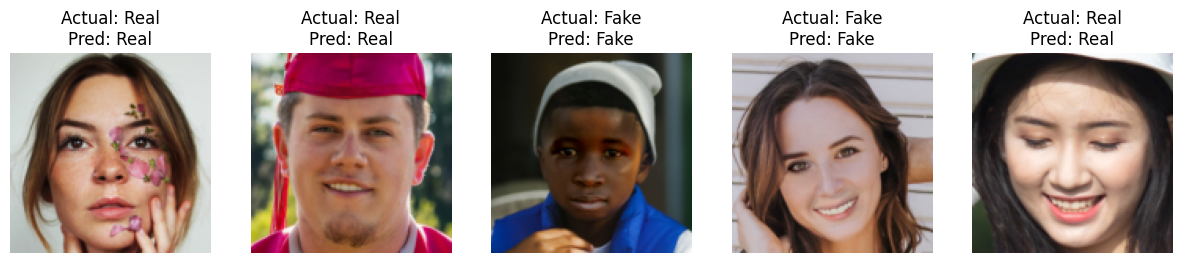

In [19]:
def predict_and_show(model, loader):
  model.eval()
  images, labels = next(iter(loader))
  images, labels = images.to(device), labels.to(device)

  outputs = model(images)
  preds = (outputs > 0.5).int()

  fig, ax = plt.subplots(1, 5, figsize = (15, 3))
  for i in range(5):
    img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
    actual = "Real" if labels[i] == 1 else "Fake"
    predicted = "Real" if preds[i] == 1 else "Fake"
    ax[i].imshow(img)
    ax[i].set_title(f"Actual: {actual}\nPred: {predicted}")
    ax[i].axis('off')

predict_and_show(model, val_loader)

**Evaluation Metrics**

Let's compute accuracy, precision, recall and confusion matrix

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def evaluate_metrics(model, loader):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for images, labels in loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      preds = (outputs > 0.5).int().cpu().numpy()
      all_preds.extend(preds)
      all_labels.extend(labels.cpu().numpy())

    #convert to numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    #Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("Confusion Matrix:\n", cm)

evaluate_metrics(model, val_loader)


Accuracy: 0.6601
Precision: 0.6758
Recall: 0.6852
Confusion Matrix:
 [[122  71]
 [ 68 148]]


**Test on Your Own image(Real or Fake)**

In [35]:
#this cell is used tp upload an image
from google.colab import files
uploaded = files.upload()

Saving fake3.jpg to fake3.jpg


In [36]:
from PIL import Image

def predict_image(image_path, model):
  model.eval()
  img = Image.open(image_path).convert('RGB')
  img = transform(img)  #use the same transform as training
  img = img.unsqueeze(0).to(device)  #Add batch dimension

  with torch.no_grad():
    output = model(img)
    prediction = (output > 0.5).int().item()


  label = "Real" if prediction == 1 else "Fake"
  print(f"Prediction: {label}")

  #show image
  plt.imshow(Image.open(image_path))
  plt.title(f"Prediction: {label}")
  plt.axis('off')
  plt.show()


Prediction: Real


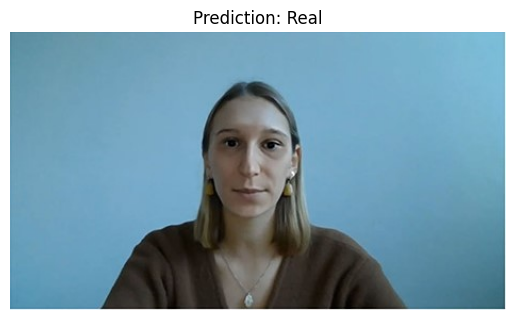

In [37]:
predict_image("fake3.jpg", model)